<a href="https://colab.research.google.com/github/AlekyaMadiReddy/Alekya_INFO5731_Fall2023/blob/main/MadiReddy_In_class_exercise_05_04182023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The fifth in-class-exercise (40 points in total, 4/18/2023)**

(20 points) The purpose of the question is to practice different machine learning algorithms for text classification as well as the performance evaluation. In addition, you are requried to conduct *10 fold cross validation (https://scikit-learn.org/stable/modules/cross_validation.html)* in the training.

The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.

Algorithms:

(1) MultinominalNB

(2) SVM

(3) KNN

(4) Decision tree

(5) Random Forest

(6) XGBoost

(7) Word2Vec

(8) BERT

Evaluation measurement:

(1) Accuracy

(2) Recall

(3) Precison

(4) F-1 score

In [65]:
# Write your code here
# Import necessary libraries
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer
from textblob import TextBlob
from textblob import Word
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn import naive_bayes
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Download stopwords for text processing
nltk.download('stopwords')

# Download WordNet for lemmatization
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [66]:
import warnings
warnings.filterwarnings('ignore')

In [67]:
def reading_data(file_path):

    # Initialize empty lists to store text data and sentiments
    text_data, sentiments = [], []

    # Read the content of the file
    file_data = open(file_path).read()

    # Process each line in the file
    for i, line in enumerate(file_data.split("\n")):
        # Split each line into words
        after_split = line.split(' ')

        # Extract text data (excluding the first element) and sentiment (first element)
        text_data.append(" ".join(after_split[1:]))
        sentiments.append(after_split[0])

    # Return the extracted text data and sentiments
    return text_data, sentiments


In [68]:

# Reading training data from a file using the reading_data function
training_text_data, training_sentiments = reading_data('/content/stsa-train.txt')

# Creating a DataFrame for training data with sentiment labels and raw text
training_df = pd.DataFrame(list(zip(training_sentiments, training_text_data)),
                            columns=['Sentimental Value', 'Raw Data'])
print(training_df)

# Reading testing data from a file using the reading_data function
testing_text_data, testing_sentiments = reading_data('/content/stsa-test.txt')

# Creating a DataFrame for testing data with sentiment labels and raw text
testing_df = pd.DataFrame(list(zip(testing_sentiments, testing_text_data)),
                           columns=['Sentimental Value', 'Raw Data'])
print(testing_df)

     Sentimental Value                                           Raw Data
0                    1  a stirring , funny and finally transporting re...
1                    0  apparently reassembled from the cutting-room f...
2                    0  they presume their audience wo n't sit still f...
3                    1  this is a visually stunning rumination on love...
4                    1  jonathan parker 's bartleby should have been t...
...                ...                                                ...
6916                 0  take care is nicely performed by a quintet of ...
6917                 0  the script covers huge , heavy topics in a bla...
6918                 0  a seriously bad film with seriously warped log...
6919                 1  a deliciously nonsensical comedy about a city ...
6920                                                                     

[6921 rows x 2 columns]
     Sentimental Value                                           Raw Data
0            

In [69]:
#Pre-processing
#removal of special characters
training_df['After noise removal'] = training_df['Raw Data'].apply(lambda x: ''.join(re.sub(r"[^a-zA-Z0-9]+", ' ', charctr) for charctr in x ))
testing_df['After noise removal'] = testing_df['Raw Data'].apply(lambda x: ''.join(re.sub(r"[^a-zA-Z0-9]+", ' ', charctr) for charctr in x ))
# removal of Punctuation
training_df['Punctuation removal'] = training_df['After noise removal'].str.replace('[^\w\s]','')
testing_df['Punctuation removal'] = testing_df['After noise removal'].str.replace('[^\w\s]','')
# Stopwords removal
stop_word = stopwords.words('english')
training_df['Stopwords removal'] = training_df['Punctuation removal'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_word))
testing_df['Stopwords removal'] = testing_df['Punctuation removal'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_word))
# Lower Casing
training_df['Lower casing'] = training_df['Stopwords removal'].apply(lambda x: " ".join(x.lower() for x in x.split()))
testing_df['Lower casing'] = testing_df['Stopwords removal'].apply(lambda x: " ".join(x.lower() for x in x.split()))
print(testing_df)
print(training_df)

     Sentimental Value                                           Raw Data  \
0                    0     no movement , no yuks , not much of anything .   
1                    0  a gob of drivel so sickly sweet , even the eag...   
2                    0  gangs of new york is an unapologetic mess , wh...   
3                    0  we never really feel involved with the story ,...   
4                    1            this is one of polanski 's best films .   
...                ...                                                ...   
1817                 0  the problem with concept films is that if the ...   
1818                 0  safe conduct , however ambitious and well-inte...   
1819                 0  a film made with as little wit , interest , an...   
1820                 0  but here 's the real damn : it is n't funny , ...   
1821                                                                        

                                    After noise removal  \
0        no move

In [118]:
tfidf_vector = TfidfVectorizer(analyzer = 'word')
tfidf_vector.fit(training_df['Lower casing'])
x =  tfidf_vector.transform(training_df['Lower casing'])
tfidf_vector_test = TfidfVectorizer(analyzer='word', vocabulary = tfidf_vector.vocabulary_)
tfidf_vector_test.fit(testing_df['Lower casing'])
test_values_x = tfidf_vector_test.transform(testing_df['Lower casing'])


In [71]:
xtrain, xvalid, ytrain, yvalid = model_selection.train_test_split(x, training_df['Sentimental Value'],test_size=0.2)

In [72]:
def csv(model, x_data, y_data):
  scoring = 'accuracy'
  kfold = KFold(10, random_state = 7, shuffle=True)
  return cross_val_score(model, x_data, y_data, cv=kfold).mean()

In [73]:
def training_model(model_initializer):

    # Initialize the model
    model = model_initializer

    # Train the model on the training data
    model.fit(xtrain, ytrain)

    # Predictions on the validation set
    predicted = model.predict(xvalid)

    # Evaluate and print accuracy and classification report for the training data
    accuracy = accuracy_score(predicted, yvalid)
    print("The Accuracy of Training data: {0}".format(accuracy))
    print(classification_report(yvalid, predicted))

    # Predictions on the testing set
    predicted_testing = model.predict(test_values_x)

    # Evaluate and print accuracy and classification report for the testing data
    accuracy_testing = accuracy_score(predicted_testing, testing_df['Sentimental Value'])
    print("The Accuracy of Testing data: {0}".format(accuracy_testing))
    print(classification_report(testing_df['Sentimental Value'], predicted_testing))

    # Cross-validation score for models other than XGBoost
    if 'XGB' not in str(model):
        print("The Cross-validation score obtained: {0}".format(csv(model, test_values_x, testing_df['Sentimental Value'])))


In [74]:
training_model(naive_bayes.MultinomialNB())

The Accuracy of Training data: 0.7956678700361011
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       640
           1       0.79      0.85      0.82       745

    accuracy                           0.80      1385
   macro avg       0.80      0.79      0.79      1385
weighted avg       0.80      0.80      0.79      1385

The Accuracy of Testing data: 0.7958287596048299
              precision    recall  f1-score   support

                   0.00      0.00      0.00         1
           0       0.86      0.71      0.78       912
           1       0.75      0.88      0.81       909

    accuracy                           0.80      1822
   macro avg       0.54      0.53      0.53      1822
weighted avg       0.80      0.80      0.79      1822

The Cross-validation score obtained: 0.7365309553834145


In [75]:
training_model(svm.SVC())

The Accuracy of Training data: 0.7819494584837545
              precision    recall  f1-score   support

           0       0.77      0.76      0.76       640
           1       0.79      0.80      0.80       745

    accuracy                           0.78      1385
   macro avg       0.78      0.78      0.78      1385
weighted avg       0.78      0.78      0.78      1385

The Accuracy of Testing data: 0.7980241492864983
              precision    recall  f1-score   support

                   0.00      0.00      0.00         1
           0       0.82      0.76      0.79       912
           1       0.78      0.83      0.80       909

    accuracy                           0.80      1822
   macro avg       0.53      0.53      0.53      1822
weighted avg       0.80      0.80      0.80      1822

The Cross-validation score obtained: 0.7217017954722873


In [76]:
training_model(KNeighborsClassifier(n_neighbors = 5))

The Accuracy of Training data: 0.4729241877256318
              precision    recall  f1-score   support

           0       0.47      0.99      0.64       640
           1       0.83      0.03      0.05       745

    accuracy                           0.47      1385
   macro avg       0.65      0.51      0.34      1385
weighted avg       0.66      0.47      0.32      1385

The Accuracy of Testing data: 0.5093304061470911
              precision    recall  f1-score   support

                   0.00      0.00      0.00         1
           0       0.51      0.99      0.67       912
           1       0.72      0.03      0.06       909

    accuracy                           0.51      1822
   macro avg       0.41      0.34      0.24      1822
weighted avg       0.61      0.51      0.36      1822

The Cross-validation score obtained: 0.5005464480874318


In [77]:
training_model(DecisionTreeClassifier())

The Accuracy of Training data: 0.6462093862815884
              precision    recall  f1-score   support

           0       0.61      0.65      0.63       640
           1       0.68      0.64      0.66       745

    accuracy                           0.65      1385
   macro avg       0.65      0.65      0.65      1385
weighted avg       0.65      0.65      0.65      1385

The Accuracy of Testing data: 0.654774972557629
              precision    recall  f1-score   support

                   0.00      0.00      0.00         1
           0       0.66      0.65      0.65       912
           1       0.65      0.66      0.66       909

    accuracy                           0.65      1822
   macro avg       0.44      0.44      0.44      1822
weighted avg       0.65      0.65      0.65      1822

The Cross-validation score obtained: 0.6158139674533116


In [78]:
training_model(RandomForestClassifier())

The Accuracy of Training data: 0.7321299638989169
              precision    recall  f1-score   support

           0       0.70      0.73      0.72       640
           1       0.76      0.74      0.75       745

    accuracy                           0.73      1385
   macro avg       0.73      0.73      0.73      1385
weighted avg       0.73      0.73      0.73      1385

The Accuracy of Testing data: 0.7458836443468716
              precision    recall  f1-score   support

                   0.00      0.00      0.00         1
           0       0.74      0.76      0.75       912
           1       0.75      0.74      0.74       909

    accuracy                           0.75      1822
   macro avg       0.50      0.50      0.50      1822
weighted avg       0.75      0.75      0.75      1822

The Cross-validation score obtained: 0.6657569206749534


(20 points) The purpose of the question is to practice different machine learning algorithms for text clustering
Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

Apply the listed clustering methods to the dataset:

K-means

DBSCAN

Hierarchical clustering

Word2Vec

BERT

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

In [79]:
#Write your code here.
import pandas as pd
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import re
from textblob import TextBlob
from nltk.stem import PorterStemmer
from textblob import Word
nltk.download('wordnet')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [80]:
data_df = pd.read_csv('/content/Amazon_Unlocked_Mobile.csv')
print(data_df)

                                             Product Name Brand Name   Price  \
0       "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
1       "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
2       "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
3       "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
4       "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
...                                                   ...        ...     ...   
413835  Samsung Convoy U640 Phone for Verizon Wireless...    Samsung   79.95   
413836  Samsung Convoy U640 Phone for Verizon Wireless...    Samsung   79.95   
413837  Samsung Convoy U640 Phone for Verizon Wireless...    Samsung   79.95   
413838  Samsung Convoy U640 Phone for Verizon Wireless...    Samsung   79.95   
413839  Samsung Convoy U640 Phone for Verizon Wireless...    Samsung   79.95   

        Rating                         

In [81]:
print("Shape: {0}".format(data_df.shape))

Shape: (413840, 6)


In [82]:
cluster_data_df = data_df.head(1000)
cluster_data_df

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0
...,...,...,...,...,...,...
995,5.5-Inch Unlocked Lenovo A850 3G Smartphone-(9...,NaN,161.06,3,It's a decent for the price.. I've had this on...,0.0
996,5.5-Inch Unlocked Lenovo A850 3G Smartphone-(9...,NaN,161.06,3,Is good cell phone,0.0
997,5.5-Inch Unlocked Lenovo A850 3G Smartphone-(9...,NaN,161.06,5,"Amazing phone. Cables and case included, also ...",0.0
998,5.5-Inch Unlocked Lenovo A850 3G Smartphone-(9...,NaN,161.06,5,Excelent,0.0


In [83]:
# Removal of special characters
cluster_data_df['After noise removal'] = cluster_data_df['Reviews'].apply(lambda x: ''.join(re.sub(r"[^a-zA-Z0-9]+", ' ', char) for char in x))

# Removal of punctuations
cluster_data_df['Punctuation removal'] = cluster_data_df['After noise removal'].str.replace('[^\w\s]', '')

# Removing numbers
cluster_data_df['Remove numbers'] = cluster_data_df['Punctuation removal'].str.replace('\d+', '')

# Removal of stopwords
stop_words = stopwords.words('english')
cluster_data_df['Stopwords removal'] = cluster_data_df['Remove numbers'].apply(lambda x: " ".join(word for word in x.split() if word.lower() not in stop_words))

# Lowercasing
cluster_data_df['Lowercasing'] = cluster_data_df['Stopwords removal'].apply(lambda x: x.lower())

# Tokenization
cluster_data_df['Tokenization'] = cluster_data_df['Lowercasing'].apply(lambda x: TextBlob(x).words)

# Stemming
porter_stemmer = PorterStemmer()
cluster_data_df['Stemming'] = cluster_data_df['Tokenization'].apply(lambda x: " ".join([porter_stemmer.stem(word) for word in x]))

# Lemmatization
cluster_data_df['Lemmatization'] = cluster_data_df['Stemming'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# Display the processed data
cluster_data_df


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,After noise removal,Punctuation removal,Remove numbers,Stopwords removal,Lowercasing,Tokenization,Stemming,Lemmatization
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0,I feel so LUCKY to have found this used phone...,I feel so LUCKY to have found this used phone...,I feel so LUCKY to have found this used phone...,feel LUCKY found used phone us used hard phone...,feel lucky found used phone us used hard phone...,"[feel, lucky, found, used, phone, us, used, ha...",feel lucki found use phone us use hard phone l...,feel lucki found use phone u use hard phone li...
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0,nice phone nice up grade from my pantach revu...,nice phone nice up grade from my pantach revu...,nice phone nice up grade from my pantach revu...,nice phone nice grade pantach revue clean set ...,nice phone nice grade pantach revue clean set ...,"[nice, phone, nice, grade, pantach, revue, cle...",nice phone nice grade pantach revu clean set e...,nice phone nice grade pantach revu clean set e...
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0,Very pleased,Very pleased,Very pleased,pleased,pleased,[pleased],pleas,plea
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0,It works good but it goes slow sometimes but i...,It works good but it goes slow sometimes but i...,It works good but it goes slow sometimes but i...,works good goes slow sometimes good phone love,works good goes slow sometimes good phone love,"[works, good, goes, slow, sometimes, good, pho...",work good goe slow sometim good phone love,work good goe slow sometim good phone love
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0,Great phone to replace my lost phone The only...,Great phone to replace my lost phone The only...,Great phone to replace my lost phone The only...,Great phone replace lost phone thing volume bu...,great phone replace lost phone thing volume bu...,"[great, phone, replace, lost, phone, thing, vo...",great phone replac lost phone thing volum butt...,great phone replac lost phone thing volum butt...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5.5-Inch Unlocked Lenovo A850 3G Smartphone-(9...,NaN,161.06,3,It's a decent for the price.. I've had this on...,0.0,It s a decent for the price I ve had this on...,It s a decent for the price I ve had this on...,It s a decent for the price I ve had this on...,decent price one months cons pretty frequently...,decent price one months cons pretty frequently...,"[decent, price, one, months, cons, pretty, fre...",decent price one month con pretti frequent una...,decent price one month con pretti frequent una...
996,5.5-Inch Unlocked Lenovo A850 3G Smartphone-(9...,NaN,161.06,3,Is good cell phone,0.0,Is good cell phone,Is good cell phone,Is good cell phone,good cell phone,good cell phone,"[good, cell, phone]",good cell phone,good cell phone
997,5.5-Inch Unlocked Lenovo A850 3G Smartphone-(9...,NaN,161.06,5,"Amazing phone. Cables and case included, also ...",0.0,Amazing phone Cables and case included also ...,Amazing phone Cables and case included also ...,Amazing phone Cables and case included also ...,Amazing phone Cables case included also screen...,amazing phone cables case included also screen...,"[amazing, phone, cables, case, included, also,...",amaz phone cabl case includ also screen pritec...,amaz phone cabl case includ also screen pritec...
998,5.5-Inch Unlocked Lenovo A850 3G Smartphone-(9...,NaN,161.06,5,Excelent,0.0,Excelent,Excelent,Excelent,Excelent,excelent,[excelent],excel,excel


In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
tfidf = tfidf_vect.fit_transform(cluster_data_df['Lemmatization'].values)
tfidf.shape

(1000, 2415)

In [85]:
from sklearn.cluster import KMeans

model_tf = KMeans(n_clusters=10, random_state=99)
model_tf.fit(tfidf)


KMeans(n_clusters=10, random_state=99)

In [86]:
labels_tf = model_tf.labels_
cluster_center_tf=model_tf.cluster_centers_
cluster_center_tf

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.02926381, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.00916314, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [87]:
terms1 = tfidf_vect.get_feature_names_out()


In [88]:
terms1[1:10]

array(['abil', 'abl', 'ablebto', 'absolut', 'abysm', 'accent', 'accept',
       'access', 'accessori'], dtype=object)

In [89]:
from sklearn import metrics

silhouette_score_tf = metrics.silhouette_score(tfidf, labels_tf, metric='euclidean')


In [116]:
df1 = cluster_data_df
df1['Tfidf Clus Label'] = model_tf.labels_
df1.head(15)

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,After noise removal,Punctuation removal,Remove numbers,Stopwords removal,Lowercasing,Tokenization,Stemming,Lemmatization,Tfidf Clus Label,Bow Clus Label,AVG-W2V Clus Label
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0,I feel so LUCKY to have found this used phone...,I feel so LUCKY to have found this used phone...,I feel so LUCKY to have found this used phone...,feel LUCKY found used phone us used hard phone...,feel lucky found used phone us used hard phone...,"[feel, lucky, found, used, phone, us, used, ha...",feel lucki found use phone us use hard phone l...,feel lucki found use phone u use hard phone li...,5,9,0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0,nice phone nice up grade from my pantach revu...,nice phone nice up grade from my pantach revu...,nice phone nice up grade from my pantach revu...,nice phone nice grade pantach revue clean set ...,nice phone nice grade pantach revue clean set ...,"[nice, phone, nice, grade, pantach, revue, cle...",nice phone nice grade pantach revu clean set e...,nice phone nice grade pantach revu clean set e...,5,0,0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0,Very pleased,Very pleased,Very pleased,pleased,pleased,[pleased],pleas,plea,4,0,1
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0,It works good but it goes slow sometimes but i...,It works good but it goes slow sometimes but i...,It works good but it goes slow sometimes but i...,works good goes slow sometimes good phone love,works good goes slow sometimes good phone love,"[works, good, goes, slow, sometimes, good, pho...",work good goe slow sometim good phone love,work good goe slow sometim good phone love,6,0,0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0,Great phone to replace my lost phone The only...,Great phone to replace my lost phone The only...,Great phone to replace my lost phone The only...,Great phone replace lost phone thing volume bu...,great phone replace lost phone thing volume bu...,"[great, phone, replace, lost, phone, thing, vo...",great phone replac lost phone thing volum butt...,great phone replac lost phone thing volum butt...,5,9,3
5,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,1,I already had a phone with problems... I know ...,1.0,I already had a phone with problems I know ...,I already had a phone with problems I know ...,I already had a phone with problems I know ...,already phone problems know stated used dang s...,already phone problems know stated used dang s...,"[already, phone, problems, know, stated, used,...",alreadi phone problem know state use dang stat...,alreadi phone problem know state use dang stat...,5,9,0
6,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,2,The charging port was loose. I got that solder...,0.0,The charging port was loose I got that solder...,The charging port was loose I got that solder...,The charging port was loose I got that solder...,charging port loose got soldered needed new ba...,charging port loose got soldered needed new ba...,"[charging, port, loose, got, soldered, needed,...",charg port loos got solder need new batteri we...,charg port loo got solder need new batteri wel...,5,0,0
7,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,2,"Phone looks good but wouldn't stay charged, ha...",0.0,Phone looks good but wouldn t stay charged ha...,Phone looks good but wouldn t stay charged ha...,Phone looks good but wouldn t stay charged ha...,Phone looks good stay charged buy new battery ...,phone looks good stay charged buy new battery ...,"[phone, looks, good, stay, charged, buy, new, ...

In [91]:
df1.groupby(['Tfidf Clus Label'])['Reviews'].count()

Tfidf Clus Label
0     32
1     52
2     39
3     49
4    310
5    326
6     56
7     80
8     35
9     21
Name: Reviews, dtype: int64

In [92]:
print("Top terms per cluster:")
order_centroids = model_tf.cluster_centers_.argsort()[:, ::-1]
for i in range(10):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms1[ind], end='')
        print()

Top terms per cluster:
Cluster 0: great
 phone
 work
 expect
 luv
 product
 valu
 use
 price
 easi
Cluster 1: excel
 product
 recommend
 seller
 thank
 phone
 fash
 function
 five
 cellphon
Cluster 2: phone
 work
 never
 usa
 month
 call
 friend
 gift
 bought
 gave
Cluster 3: good
 phone
 product
 price
 thank
 cell
 mobil
 work
 go
 buy
Cluster 4: good
 like
 bueno
 bad
 phone
 thank
 product
 use
 expect
 muy
Cluster 5: phone
 use
 good
 card
 sim
 work
 screen
 would
 charg
 one
Cluster 6: love
 phone
 use
 buy
 like
 great
 mom
 easi
 best
 smartphon
Cluster 7: work
 phone
 return
 wast
 item
 arriv
 lousi
 money
 recommend
 charg
Cluster 8: excelent
 telefono
 muy
 bueno
 producto
 find
 foundat
 free
 freak
 frame
Cluster 9: ok
 far
 wcdma
 quit
 peopl
 someon
 buy
 slow
 enter
 oftenneg


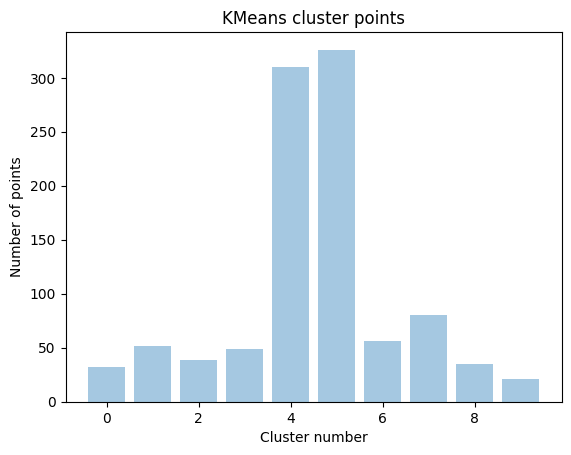

In [93]:
import matplotlib.pyplot as plt
plt.bar([x for x in range(10)], df1.groupby(['Tfidf Clus Label'])['Reviews'].count(), alpha = 0.4)
plt.title('KMeans cluster points')
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()

In [94]:
for i in range(10):
    print("Four review of assigned to the cluster: ", i)
    print("-" * 70)
    print(df1.iloc[df1.groupby(['Tfidf Clus Label']).groups[i][0]]['Reviews'])
    print('\n')
    print(df1.iloc[df1.groupby(['Tfidf Clus Label']).groups[i][5]]['Reviews'])
    print('\n')
    print(df1.iloc[df1.groupby(['Tfidf Clus Label']).groups[i][10]]['Reviews'])
    print('\n')
    print("_" * 70)

Four review of assigned to the cluster:  0
----------------------------------------------------------------------
Phone good just a little slow phone old but it's a great phone temporary right now. thank you for the great deal


Met all of my expectations. I can't complain at all. Great price!


great phablet for all general uses


______________________________________________________________________
Four review of assigned to the cluster:  1
----------------------------------------------------------------------
excellent product in perfect condition


Excellent phone has all the special functions to be communicated with all social networks, excellent operational...I recommend it 100% excellent product


Excelent


______________________________________________________________________
Four review of assigned to the cluster:  2
----------------------------------------------------------------------
Stopped working after 2 months. Not happy with this phone.


If I could've gave it 0 star

In [95]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
bow = count_vect.fit_transform(cluster_data_df['Reviews'].values)
bow.shape

(1000, 3455)

In [96]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=10, init='k-means++', random_state=99)
model.fit(bow)


KMeans(n_clusters=10, random_state=99)

In [97]:
labels = model.labels_
cluster_center=model.cluster_centers_

In [98]:
from sklearn import metrics
print(metrics.silhouette_score(bow, labels, metric='euclidean'))

0.39528026327024723


In [99]:
cluster_data_df['Bow Clus Label'] = model.labels_ # the last column you can see the label numebers
cluster_data_df.head(2)

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,After noise removal,Punctuation removal,Remove numbers,Stopwords removal,Lowercasing,Tokenization,Stemming,Lemmatization,Tfidf Clus Label,Bow Clus Label
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0,I feel so LUCKY to have found this used phone...,I feel so LUCKY to have found this used phone...,I feel so LUCKY to have found this used phone...,feel LUCKY found used phone us used hard phone...,feel lucky found used phone us used hard phone...,"[feel, lucky, found, used, phone, us, used, ha...",feel lucki found use phone us use hard phone l...,feel lucki found use phone u use hard phone li...,5,9
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0,nice phone nice up grade from my pantach revu...,nice phone nice up grade from my pantach revu...,nice phone nice up grade from my pantach revu...,nice phone nice grade pantach revue clean set ...,nice phone nice grade pantach revue clean set ...,"[nice, phone, nice, grade, pantach, revue, cle...",nice phone nice grade pantach revu clean set e...,nice phone nice grade pantach revu clean set e...,5,0


In [100]:
from sklearn.cluster import DBSCAN
import numpy as np

In [101]:
# Setting the minimum number of points for density-based clustering
minPts = 2 * 100

# Lower bound function to find the element just greater than or equal to the target in a sorted array
def lower_bound(nums, target):
    l, r = 0, len(nums) - 1
    while l <= r:
        mid = int(l + (r - l) / 2)
        if nums[mid] >= target:
            r = mid - 1
        else:
            l = mid + 1
    return l

# Computes the distance to the 200th nearest neighbor for a given data point x
def compute_200th_nearest_neighbour(x, data):
    dists = []
    for val in data:
        # Computing Euclidean distance between points
        dist = np.sum((x - val) ** 2)
        # Updating the list with the 200 smallest distances encountered so far
        if len(dists) == 200 and dists[199] > dist:
            # Finding the right position using the lower bound function
            l = int(lower_bound(dists, dist))
            # Ensuring the new distance is smaller than the current largest distance
            if 0 <= l < 200 and dists[l] > dist:
                dists[l] = dist
        else:
            dists.append(dist)
            dists.sort()

    # The 200th nearest neighbor distance is stored at index 199
    return dists[199]

In [104]:
list_of_sent_train = list()
for i in cluster_data_df["Lowercasing"].values:
    list_of_sent_train.append(i.split())

In [105]:
import gensim

w2v_model = gensim.models.Word2Vec(list_of_sent_train, vector_size=100, workers=4)

In [106]:
import numpy as np

# Initialize an empty list to store the average Word2Vec representation for each sentence/review
sent_vectors = []

# Counter for tracking the number of processed sentences/reviews
count = 1

# Iterate through each sentence/review in the training dataset
for sent in list_of_sent_train:
    # Initialize a vector of zeros with a length of 100 (size of Word2Vec vectors)
    sent_vec = np.zeros(100)

    # Initialize a counter for the number of words with a valid vector in the sentence/review
    cnt_words = 1

    # Iterate through each word in the sentence/review
    for word in sent:
        try:
            # Attempt to retrieve the Word2Vec vector for the current word
            vec = w2v_model.wv[word]

            # Add the vector to the sentence vector
            sent_vec += vec

            # Increment the word count
            cnt_words += 1
        except:
            # If the word is not in the Word2Vec model's vocabulary, ignore the exception
            pass

    # Calculate the average vector for the sentence/review
    sent_vec /= cnt_words

    # Append the average vector to the list of sentence vectors
    sent_vectors.append(sent_vec)

# Convert the list of sentence vectors to a NumPy array
sent_vectors = np.array(sent_vectors)

# Replace any NaN values with zeros
sent_vectors = np.nan_to_num(sent_vectors)


In [107]:
twohundrethneigh = []
for val in sent_vectors[:300]:
    twohundrethneigh.append(compute200thnearestneighbour(val, sent_vectors[:300]) )
twohundrethneigh.sort()

In [108]:
model = DBSCAN(eps = 5, min_samples = minPts, n_jobs=-1)
model.fit(sent_vectors)

DBSCAN(eps=5, min_samples=200, n_jobs=-1)

In [109]:
cluster_data_df['AVG-W2V Clus Label'] = model.labels_
cluster_data_df.head(2)

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,After noise removal,Punctuation removal,Remove numbers,Stopwords removal,Lowercasing,Tokenization,Stemming,Lemmatization,Tfidf Clus Label,Bow Clus Label,AVG-W2V Clus Label
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0,I feel so LUCKY to have found this used phone...,I feel so LUCKY to have found this used phone...,I feel so LUCKY to have found this used phone...,feel LUCKY found used phone us used hard phone...,feel lucky found used phone us used hard phone...,"[feel, lucky, found, used, phone, us, used, ha...",feel lucki found use phone us use hard phone l...,feel lucki found use phone u use hard phone li...,5,9,0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0,nice phone nice up grade from my pantach revu...,nice phone nice up grade from my pantach revu...,nice phone nice up grade from my pantach revu...,nice phone nice grade pantach revue clean set ...,nice phone nice grade pantach revue clean set ...,"[nice, phone, nice, grade, pantach, revue, cle...",nice phone nice grade pantach revu clean set e...,nice phone nice grade pantach revu clean set e...,5,0,0


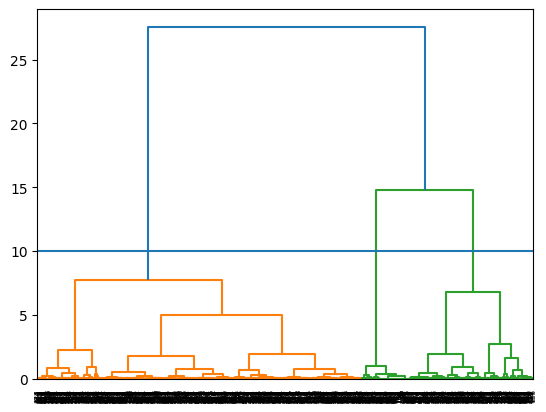

In [110]:
import scipy
from scipy.cluster import hierarchy
dendro = hierarchy.dendrogram(hierarchy.linkage(sent_vectors,method = 'ward'))
plt.axhline(y = 10) # cut at 30 to get 5 clusters

In [111]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  #took n=5 from dendrogram curve
Agg=cluster.fit_predict(sent_vectors)

In [112]:
#Giving Labels/assigning a cluster to each point/text
aggdfa = cluster_data_df
aggdfa['AVG-W2V Clus Label'] = cluster.labels_
aggdfa.head(2)

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,After noise removal,Punctuation removal,Remove numbers,Stopwords removal,Lowercasing,Tokenization,Stemming,Lemmatization,Tfidf Clus Label,Bow Clus Label,AVG-W2V Clus Label
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0,I feel so LUCKY to have found this used phone...,I feel so LUCKY to have found this used phone...,I feel so LUCKY to have found this used phone...,feel LUCKY found used phone us used hard phone...,feel lucky found used phone us used hard phone...,"[feel, lucky, found, used, phone, us, used, ha...",feel lucki found use phone us use hard phone l...,feel lucki found use phone u use hard phone li...,5,9,0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0,nice phone nice up grade from my pantach revu...,nice phone nice up grade from my pantach revu...,nice phone nice up grade from my pantach revu...,nice phone nice grade pantach revue clean set ...,nice phone nice grade pantach revue clean set ...,"[nice, phone, nice, grade, pantach, revue, cle...",nice phone nice grade pantach revu clean set e...,nice phone nice grade pantach revu clean set e...,5,0,0


In [113]:
aggdfa.groupby(['AVG-W2V Clus Label'])['Reviews'].count()

AVG-W2V Clus Label
0    528
1    102
2     97
3    126
4    147
Name: Reviews, dtype: int64

In [114]:
for i in range(5):
    print("Two reviews of assigned to cluster ", i)
    print("-" * 70)
    print(aggdfa.iloc[aggdfa.groupby(['AVG-W2V Clus Label']).groups[i][0]]['Reviews'])
    print('\n')
    print(aggdfa.iloc[aggdfa.groupby(['AVG-W2V Clus Label']).groups[i][1]]['Reviews'])
    print('\n')
    print("_" * 70)

Two reviews of assigned to cluster  0
----------------------------------------------------------------------
I feel so LUCKY to have found this used (phone to us & not used hard at all), phone on line from someone who upgraded and sold this one. My Son liked his old one that finally fell apart after 2.5+ years and didn't want an upgrade!! Thank you Seller, we really appreciate it & your honesty re: said used phone.I recommend this seller very highly & would but from them again!!


nice phone, nice up grade from my pantach revue. Very clean set up and easy set up. never had an android phone but they are fantastic to say the least. perfect size for surfing and social media. great phone samsung


______________________________________________________________________
Two reviews of assigned to cluster  1
----------------------------------------------------------------------
Very pleased


as described, fast ship!


______________________________________________________________________
Two 

In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.

In [115]:
#You can write you answer here. (No code needed)
"""
A huge dataset is divided into a set number of clustes using k-means, which then generalizes them into various sizes and shapes. While it performs well with huge datasets, it is less effective with noisy data.
To distinguish between high-density and low-density clusters, DBscan is utilized. While it does well on noisy data, it struggles on huge datasets.
Similar items are grouped together into groupings known as clusters using a technique called hierarchical clustering. Using Hierarchical C to categorize the clusters is difficult.
"""

'\nA huge dataset is divided into a set number of clustes using k-means, which then generalizes them into various sizes and shapes. While it performs well with huge datasets, it is less effective with noisy data. \nTo distinguish between high-density and low-density clusters, DBscan is utilized. While it does well on noisy data, it struggles on huge datasets. \nSimilar items are grouped together into groupings known as clusters using a technique called hierarchical clustering. Using Hierarchical C to categorize the clusters is difficult.\n'